In [ ]:
!pip install wandb

Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import wandb
from wandb.keras import WandbCallback
from sklearn.metrics import confusion_matrix

In [13]:
wandb.init(project="Sheykh Recognition")

accuracy,▁▅▆▇▇█▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆▆▆▆▆▇▆▆▇▇▇▆█▆█▇▆▇
val_loss,█▃▂▂▂▃▂▂▂▃▂▂▃▃▂▃▁▃▄▂
accuracy,0.98592
best_epoch,16
best_val_loss,0.18872
epoch,19
loss,0.08302
val_accuracy,0.89796


In [ ]:
train_dataset_path = "/content/drive/MyDrive/Dataset/Sheykh/Train"
width = height = 224
batchSize = 32

idg = ImageDataGenerator(
    rescale=1./255,

    # Augmentation
    horizontal_flip=True,
    brightness_range=(0.7, 1.3),
    rotation_range=15,
    zoom_range=0.2,
    shear_range=0.1,

    validation_split=0.15
)

train_data = idg.flow_from_directory(
    train_dataset_path,
    target_size=(width, height),
    class_mode="categorical",
    batch_size=batchSize,
    subset="training"
)

val_data = idg.flow_from_directory(
    train_dataset_path,
    target_size=(width, height),
    class_mode="categorical",
    batch_size=batchSize,
    subset="validation"
)

Found 284 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


Model

In [ ]:
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(width, height, 3),
    pooling="avg"
)

for layer in base_model.layers[:-4]:
    layer.trainable = False

model = tf.keras.models.Sequential([
    base_model,

    # layers.Flatten(),
    # layers.Dense(1024, activation="relu"),
    layers.Dense(2, activation="softmax")
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["accuracy"]
)

In [ ]:
model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[WandbCallback()])

Epoch 1/20
9/9 [==============================] - 25s 2s/step - loss: 0.7744 - accuracy: 0.5458 - val_loss: 0.6252 - val_accuracy: 0.6531 - _timestamp: 1647505310.0000 - _runtime: 64.0000
Epoch 2/20
9/9 [==============================] - 12s 1s/step - loss: 0.4858 - accuracy: 0.7817 - val_loss: 0.3243 - val_accuracy: 0.8571 - _timestamp: 1647505323.0000 - _runtime: 77.0000
Epoch 3/20
9/9 [==============================] - 11s 1s/step - loss: 0.3521 - accuracy: 0.8732 - val_loss: 0.2714 - val_accuracy: 0.8776 - _timestamp: 1647505334.0000 - _runtime: 88.0000
Epoch 4/20
9/9 [==============================] - 11s 1s/step - loss: 0.2908 - accuracy: 0.8979 - val_loss: 0.2530 - val_accuracy: 0.8776 - _timestamp: 1647505345.0000 - _runtime: 99.0000
Epoch 5/20
9/9 [==============================] - 10s 1s/step - loss: 0.2282 - accuracy: 0.9296 - val_loss: 0.2645 - val_accuracy: 0.8776 - _timestamp: 1647505355.0000 - _runtime: 109.0000
Epoch 6/20
9/9 [==============================] - 10s 1s/st

Save

In [9]:
model.save('sheykhRecognition_model.h5')

Test

In [10]:
test_dataset_path = "/content/drive/MyDrive/Dataset/Sheykh/Test"
width = height = 224
batchSize = 32

idg = ImageDataGenerator(
    rescale=1./255
)

test_data = idg.flow_from_directory(
    test_dataset_path,
    target_size=(width, height),
    class_mode="categorical",
    batch_size=batchSize
)

Found 56 images belonging to 2 classes.


In [11]:
model.evaluate(test_data)

2/2 [==============================] - 2s 2s/step - loss: 0.0568 - accuracy: 1.0000


[0.05675332620739937, 1.0]

Confusion Matrix

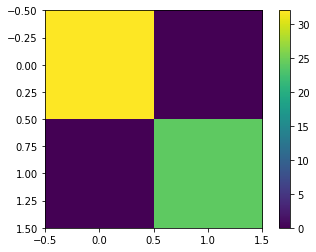

In [12]:
Y_pred = []

for path in test_data.filepaths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (width, height))
    image = image / 255
    image = image.reshape(1, width, height, 3)
    Y_pred.append(np.argmax(model.predict(image)))

conf_mat = confusion_matrix(test_data.classes, Y_pred)
plt.imshow(conf_mat)
plt.colorbar()

Inference

In [18]:
image = cv2.imread("/content/h2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 bar khalaf tf
image = cv2.resize(image, (width, height))
image = image / 255 # normalize
image = image.reshape(1, width, height, 3) # 3d -> 4d (batch_size)

result = model.predict(image)

pred = np.argmax(result)
if pred == 0:
    print("Normal People")
elif pred == 1:
    print("Sheykh")

Sheykh
